<a href="https://colab.research.google.com/github/ayarii/learner-engagement/blob/main/Copy_of_Untitled32_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os
import zipfile
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split



In [2]:

#Import dataset
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/ayarii/learner-engagement/blob/main/Student-engagement-dataset.zip?raw=true",
    extract=False)
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
data_dir = pathlib.Path('/content/datasets/Student-engagement-dataset')
print(data_dir)
print(os.path.abspath(data_dir))



40069772/40069772 [==============================] - 0s 0us/step
/content/datasets/Student-engagement-dataset
/content/datasets/Student-engagement-dataset


In [3]:
import shutil

# Chemin vers le dossier contenant vos dossiers d'ensemble de données
data_dir = '/content/datasets/Student-engagement-dataset'

# Chemin vers le dossier où vous souhaitez placer les ensembles de traitement et de validation
output_dir = '/content/datasets'

# Liste des noms de dossiers dans votre ensemble de données
folder_names = os.listdir(data_dir)

# Création des dossiers de traitement et de validation s'ils n'existent pas déjà
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Répartition des données en ensembles de traitement et de validation
for folder_name in folder_names:
    folder_path = os.path.join(data_dir, folder_name)
    images = os.listdir(folder_path)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Création des sous-dossiers dans les ensembles de traitement et de validation
    train_folder_path = os.path.join(train_dir, folder_name)
    val_folder_path = os.path.join(val_dir, folder_name)
    os.makedirs(train_folder_path, exist_ok=True)
    os.makedirs(val_folder_path, exist_ok=True)

    # Déplacement des images dans les sous-dossiers correspondants
    for image in train_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(train_folder_path, image))
    for image in val_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(val_folder_path, image))

print("Données divisées en ensembles de traitement et de validation avec succès.")



Données divisées en ensembles de traitement et de validation avec succès.


In [4]:
# Chemin vers les dossiers d'entraînement et de validation
train_dir = '/content/datasets/train/'
val_dir = '/content/datasets/validation/'

# Fonction pour compter le nombre total d'images dans un dossier
def count_images_in_directory(directory):
    total_images = 0
    # Parcours de chaque sous-dossier dans le répertoire
    for sub_directory in os.listdir(directory):
        sub_directory_path = os.path.join(directory, sub_directory)
        # Comptage des fichiers dans le sous-dossier
        if os.path.isdir(sub_directory_path):
            num_images = len([filename for filename in os.listdir(sub_directory_path)
                              if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg')])
            total_images += num_images
    return total_images

# Comptage du nombre total d'images dans chaque dossier
total_train_images = count_images_in_directory(train_dir)
total_val_images = count_images_in_directory(val_dir)

# Affichage du nombre total d'images dans chaque dossier
print("Nombre total d'images dans le dossier d'entraînement :", total_train_images)
print("Nombre total d'images dans le dossier de validation :", total_val_images)


Nombre total d'images dans le dossier d'entraînement : 1694
Nombre total d'images dans le dossier de validation : 426


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


# Data augmentation pour la partie de validation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Chemin vers le dossier de validation
val_datagen_dir = '/content/datasets/validation'

# Application de la data augmentation aux images de validation
for folder_name in os.listdir(val_datagen_dir):
    folder_path = os.path.join(val_datagen_dir, folder_name)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = load_img(img_path)  # Charger l'image
        x = img_to_array(img)  # Convertir l'image en tableau numpy
        x = x.reshape((1,) + x.shape)  # Remodeler l'image
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=folder_path, save_prefix='aug', save_format='jpg'):
            i += 1
            if i >= 5:  # Nombre d'images augmentées souhaitées par image d'origine
                break  # Arrêter la boucle après avoir généré le nombre spécifié d'images augmentées


In [6]:
# afficher le nombre d'image après l'application de DA
# Nombre initial d'images dans le dossier de validation
initial_num_images = sum([len(files) for _, _, files in os.walk(val_dir)])

# Nombre d'images augmentées par image d'origine
augmentation_factor = 5

# Nouveau nombre d'images après l'application de la data augmentation
new_num_images = initial_num_images * (augmentation_factor + 1)  # 1 pour l'image d'origine

print("Nouveau nombre d'images après application de la data augmentation :", new_num_images)


Nouveau nombre d'images après application de la data augmentation : 15102


In [7]:
# Chemin vers les dossiers d'entraînement et de validation de l'ancienne dataset
old_train_dir = '/content/datasets/train/'
old_val_dir = '/content/datasets/validation/'

# Nombre d'images dans l'ancienne dataset
old_train_images = sum([len(files) for _, _, files in os.walk(old_train_dir)])
old_val_images = sum([len(files) for _, _, files in os.walk(old_val_dir)])
old_total_images = old_train_images + old_val_images

# Nouveau nombre d'images dans le dossier de validation après data augmentation
new_val_images = old_val_images * (5 + 1)  # 5 images augmentées + 1 image d'origine
new_total_images = old_train_images + new_val_images

# Affichage des chiffres
print("Ancienne Dataset :")
print("Train :", old_train_images)
print("Validation :", old_val_images)
print("Total :", old_total_images)
print("\nNouvelle Dataset (avec data augmentation) :")
print("Train :", old_train_images)  # Le nombre d'images d'entraînement reste le même
print("Validation :", new_val_images)
print("Total :", new_total_images)


Ancienne Dataset :
Train : 1694
Validation : 2517
Total : 4211

Nouvelle Dataset (avec data augmentation) :
Train : 1694
Validation : 15102
Total : 16796


In [8]:
# Création des générateurs de données pour l'entraînement et la validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical')

Found 1694 images belonging to 6 classes.
Found 2517 images belonging to 6 classes.


In [9]:

#create the model
num_classes = 6
img_size = (200, 200,3)
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(200, 200, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        9

In [10]:

# Set up callbacks
log_dir = "logs/"
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [11]:

# Compile your model

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])



In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[tensorboard_callback, early_stopping])

Epoch 1/100
53/53 [==============================] - 23s 348ms/step - loss: 1.6403 - accuracy: 0.3979 - val_loss: 1.5954 - val_accuracy: 0.4247
Epoch 2/100
53/53 [==============================] - 16s 304ms/step - loss: 0.4928 - accuracy: 0.8123 - val_loss: 3.2443 - val_accuracy: 0.5105
Epoch 3/100
53/53 [==============================] - 16s 295ms/step - loss: 0.1874 - accuracy: 0.9274 - val_loss: 4.5756 - val_accuracy: 0.5256
Epoch 4/100
53/53 [==============================] - 17s 317ms/step - loss: 0.1402 - accuracy: 0.9368 - val_loss: 5.0993 - val_accuracy: 0.5352
Epoch 5/100
53/53 [==============================] - 17s 315ms/step - loss: 0.1217 - accuracy: 0.9410 - val_loss: 5.3383 - val_accuracy: 0.5407
Epoch 6/100
53/53 [==============================] - 16s 303ms/step - loss: 0.1182 - accuracy: 0.9398 - val_loss: 5.5045 - val_accuracy: 0.5280


In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator, verbose=0)
print(f'vall loss: {loss:.4f}')
print(f'vall accuracy: {accuracy:.4f}')

vall loss: 1.5954
vall accuracy: 0.4247


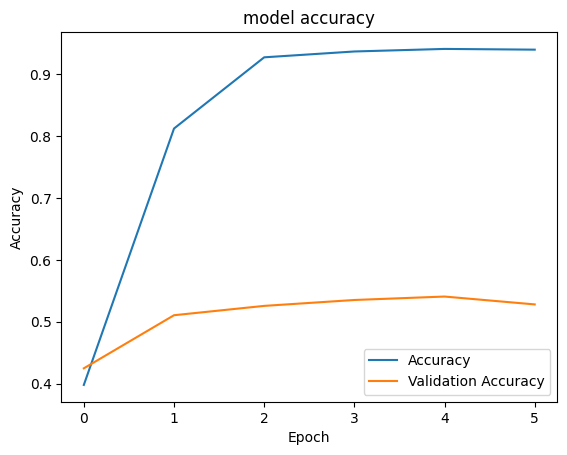

In [14]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

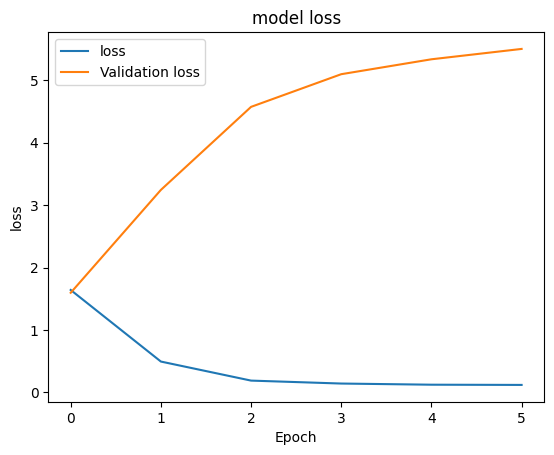

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation loss"])
plt.show()